In [2]:
%pip install torch torchvision opencv-python numpy matplotlib pillow scipy scikit-learn tqdm

import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
train_img_path = "./dataset/part_A_final/train_data/images"
train_gt_path  = "./dataset/part_A_final/train_data/ground_truth"


In [4]:
def generate_density_map(img, points, sigma_factor=0.3):

    h, w = img.shape[:2]
    density = np.zeros((h, w), dtype=np.float32)

    # If no points, return zero map
    if len(points) == 0:
        return density

    # Place "1" at each head location
    for p in points:
        y, x = int(p[1]), int(p[0])
        if 0 <= x < w and 0 <= y < h:
            density[y, x] = 1.0

    # Build KDTree for adaptive sigma
    tree = KDTree(points.copy())
    distances, _ = tree.query(points, k=4)

    if len(points) > 3:
        sigmas = distances[:, 1:4].mean(axis=1)
        sigma = np.mean(sigmas) * sigma_factor
    else:
        sigma = np.mean([h, w]) * 0.01

    # Apply Gaussian ONCE
    density = gaussian_filter(density, sigma=sigma)

    return density


In [5]:
def downsample_density_map(density, factor=8):
    H, W = density.shape
    new_H, new_W = H // factor, W // factor

    density_down = cv2.resize(density, (new_W, new_H), interpolation=cv2.INTER_CUBIC)

    # Count preservation
    density_down *= (factor * factor)

    return density_down


In [6]:
def normalize(img):
    img = img.astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    return (img - mean) / std


In [7]:
def visualize_density(img_resized, density_full, points, idx=0):

    plt.figure(figsize=(18,5))

    # 1. Image
    plt.subplot(1,3,1)
    plt.imshow(img_resized)
    plt.title(f"Image #{idx}")
    plt.axis("off")

    # 2. Density map (full resolution)
    plt.subplot(1,3,2)
    plt.imshow(density_full, cmap="jet")
    plt.title(f"Density Map (sum={density_full.sum():.1f})")
    plt.axis("off")

    # 3. Heatmap overlay
    plt.subplot(1,3,3)
    plt.imshow(img_resized)
    plt.imshow(density_full, cmap='jet', alpha=0.5)
    plt.title("Heatmap Overlay")
    plt.axis("off")

    plt.show()


In [8]:
save_img_train = "./processed/train/images"
save_den_train = "./processed/train/density"

os.makedirs(save_img_train, exist_ok=True)
os.makedirs(save_den_train, exist_ok=True)

print("Saving to:", save_img_train)


Saving to: ./processed/train/images


  0%|          | 0/300 [00:00<?, ?it/s]

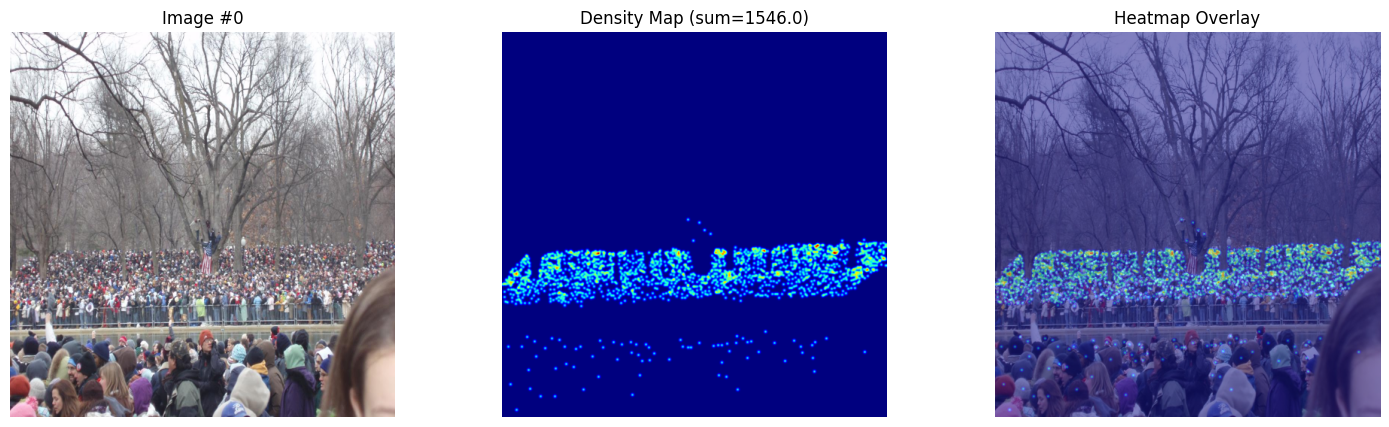

100%|██████████| 300/300 [02:12<00:00,  2.26it/s]

Preprocessing complete ✔


In [9]:
train_imgs = sorted(os.listdir(train_img_path))

for i, img_name in enumerate(tqdm(train_imgs)):

    # Load image
    img_path = os.path.join(train_img_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = img.shape[:2]

    # Resize image → 512x512
    img_resized = cv2.resize(img, (512, 512))

    # Load ground-truth points
    gt_path = os.path.join(train_gt_path, "GT_" + img_name.replace(".jpg", ".mat"))
    gt = loadmat(gt_path)
    points = gt["image_info"][0][0][0][0][0]

    # Scale points based on resize
    scale_w = 512 / orig_w
    scale_h = 512 / orig_h

    points_scaled = points.copy()
    points_scaled[:, 0] *= scale_w
    points_scaled[:, 1] *= scale_h

    # Generate full resolution density
    density_full = generate_density_map(img_resized, points_scaled)

    # Visualize ONLY FIRST IMAGE for sanity check
    if i == 0:
        visualize_density(img_resized, density_full, points_scaled, idx=i)

    # Downsample to 64x64
    density_down = downsample_density_map(density_full)

    # Normalize image for training
    img_norm = normalize(img_resized)

    # Save files
    np.save(os.path.join(save_img_train, img_name.replace(".jpg", ".npy")), img_norm)
    np.save(os.path.join(save_den_train, img_name.replace(".jpg", ".npy")), density_down)

print("Preprocessing complete ✔")


In [10]:
from torch.utils.data import Dataset, DataLoader

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img = np.load(os.path.join(self.img_dir, fname))
        den = np.load(os.path.join(self.den_dir, fname))

        img = torch.from_numpy(img).permute(2,0,1).float()
        den = torch.from_numpy(den).unsqueeze(0).float()

        return img, den


In [11]:
dataset = CrowdDataset(save_img_train, save_den_train)
img, den = dataset[0]

print("Image shape:", img.shape)    # Expect (3, 512, 512)
print("Density shape:", den.shape)  # Expect (1, 64, 64)
print("Density sum:", den.sum().item())  # ≈ number of people


Image shape: torch.Size([3, 512, 512])
Density shape: torch.Size([1, 64, 64])
Density sum: 1642.233642578125
